In [17]:
from functools import partial
import numpy as np
import tensorflow as tf
#import jax
#from jax.config import config

#config.update("jax_enable_x64", True)
#from jax import numpy as jnp
#from jax.experimental import optimizers
import tensorcircuit as tc
import math
import matplotlib.pyplot as plt

In [18]:
K = tc.set_backend("tensorflow")
zz = np.kron(tc.gates._z_matrix, tc.gates._z_matrix)

qubit = 5
level = 5
batch = 6
h = [3 for i in range(level)]


def rzz(c,i,j, params):
    c.cnot(i,i+1)
    c.rz(i+1,theta=params[j, 0])
    c.cnot(i,i+1)
    return c

def energy(c: tc.Circuit):
    e = 0.0
    n = c._nqubits
    for i in range(n):
        e += h[i] * c.expectation((tc.gates.x(), [i]))  # <X_i>
    for i in range(n - 1):  # OBC
        e += (-1.0) * c.expectation(
            (tc.gates.z(), [i]), (tc.gates.z(), [(i + 1) % n])
        )  # <Z_iZ_{i+1}>
    return tc.backend.real(e)
    

def ex(params):
    c=tc.Circuit(qubit)
    k=level
    for i in range(qubit):
        c.h(i)
    for j in range(k):
        for i in range(qubit):
            c.rx(i,theta=params[j, 1])
        for i in range(qubit-1):
            c = rzz(c,i,j, params)
    return energy(c)

ex_vg = tc.backend.jit(tc.backend.vvag(ex, argnums=0, vectorized_argnums=0))

-7.933343


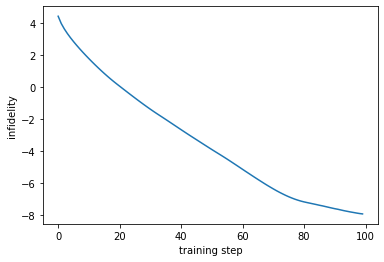

In [16]:
params = P
history = [ ]
opt = K.optimizer(tf.keras.optimizers.Adam(1e-2))

for _ in range(100):
    v, g = ex_vg(params)
    params = opt.update(g, params)
    history.append(np.min(v.numpy()))

plt.plot([i for i in range(100)], history)
plt.ylabel("infidelity")
plt.xlabel("training step")

print(history[-1])